## Introductory Machine Learning: Assignment 4

In this assignment you'll gain some hands-on experience with principal components analysis (PCA).

The assignment has three problems. The first problem investigates PCA and linear regression on a simple toy data set. The second two problems use the MNIST and Fashion MNIST data, and the database of faces that we began looking at during this week's lectures. In the second problem, you will study how different numbers of principal components represent the images visually. For third problem you will use logistic regression to predict the class label of images using the principal components representation of the images, and examine how the classification error changes with the number of principal components used. 

For the second two problems, once you get your code to work on MNIST, it should be straightforward to just copy/paste the code and then run it on Fashion MNIST and the face data. You may wish to review the notebook `pca-demo.ipynb` discussed in class before beginning these problems.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Problem 1: Principal components and least squares (20 Points)

In least-squares regression one of the assumptions made is that the explanatory variables are non-random and contain no measurement error. Therefore, the size of the residuals (vertical distances between each observed values of the response variable and the line) completely characterize the loss due to a given line. However, it is often the case that explanatory variables do have some randomness in them, in which case we may wish to characterize the loss with the orthogonal distances between data points and the line. This can be done with what is called Principal Component Regression, which you will use in this problem.

#### Part (a)

The cell below simulates two independent random variables, each from a Normal distribution with mean $0$. It then rotates the data by an angle $\dfrac{\pi}{3}$. What is the slope and intercept of a horizontal line after it has been rotated about the origin by $\dfrac{\pi}{3}$ radians and shifted up by 2 in the y axis? Add a line with this slope and intercept to the plot generated in the following cell.

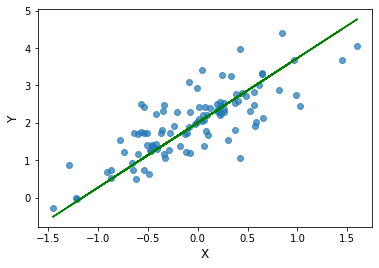

In [29]:
np.random.seed(265)
X = np.vstack((np.random.normal(0, 1, size=100), 
               np.random.normal(0, 0.3, size=100))).T

theta = np.pi/3
R = np.array([np.cos(theta), np.sin(theta), 
              -np.sin(theta), np.cos(theta)]).reshape(2,2)
X = np.dot(X, R)
X[:,1] = X[:,1]+2

plt.scatter(np.array(X[:,0]), np.array(X[:,1]), 
            alpha=.70)
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

plt.plot(X[:,0], 2 + np.tan(np.pi/3) * X[:,0], 'g')

plt.show()

Slope = tan($\pi$/3) = 1.73

Intercept = 2.0

#### Part (b)

Use least-squares regression to fit a line (with a slope and intercept) to the data generated above. Create a plot that displays the data, the true line, and the least-squares regression line. Be sure to label the two lines with legends in your plot!

You could use `statsmodels.api.OLS` to fit the "ordinary least-squares" regression, or any other function of your choice.


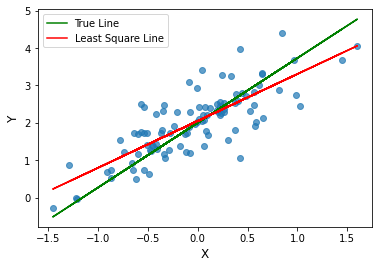

In [30]:
beta_1 = np.cov(X[:,0], X[:,1])[0,1]/ np.cov(X[:,0], 
                                             X[:,1])[0,0]
beta_0 = np.mean(X[:,1]) - (beta_1 * np.mean(X[:,0]))

plt.scatter(np.array(X[:,0]), np.array(X[:,1]), alpha=.70)
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

plt.plot(X[:,0], 2 + np.tan(np.pi/3) * X[:,0], 'g')
plt.plot(X[:,0], beta_0 + beta_1 * X[:,0], 'r')

plt.legend(['True Line', 'Least Square Line'])


plt.show()

#### Part (c)

Now fit a line to the data by projecting onto the first principal component. What is the slope of the line created by the first principal component, and how does it relate to the true slope? Create a plot with all three lines, including those you constructed in parts (a) and (b). Please label your plots.

The slope of the line created by the first principal component is 1.76
The slope of the true line is 1.73


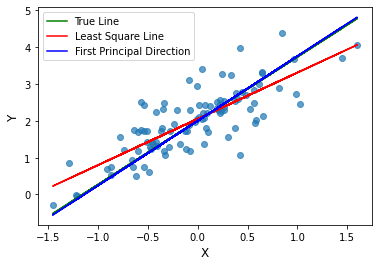

In [31]:
Xtilde = X - np.mean(X, axis = 0)
C = (1/Xtilde.shape[0]) * Xtilde.T @ Xtilde
evalues, evectors = np.linalg.eigh(C)
principal_vectors = evectors[np.argsort(-1*evalues)]
pc1 = principal_vectors[0]
slope = pc1[1]/pc1[0]

plt.scatter(np.array(X[:,0]), np.array(X[:,1]), alpha=.70)
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

plt.plot(X[:,0], 2 + np.tan(np.pi/3) * X[:,0], 
         'g')
plt.plot(X[:,0], beta_0 + beta_1 * X[:,0], 
         'r')
plt.plot(X[:,0], np.mean(X[:,1]) + slope * X[:,0], 
         'b')

plt.legend(['True Line', 'Least Square Line', 
            'First Principal Direction'])
print("The slope of the line created by the first principal component is", 
      round(slope,2))
print("The slope of the true line is", round(np.tan(np.pi/3),2))

plt.show()

The slope of the line created by the first principal component is only slightly larger than the slope of the true line. The reason why these values are so close to each other is because the first principal component is the direction of the greatest variance, which is similar to the true line (where sigma is equal to 1).

#### Part (d)

Explain why least-squares regression and principal components analysis give different fits to the data in part (c).
Can you say that one fit is better than the other? Why or why not?

Least-squares regression fits a line through the data by minimizing the sum of squared residuals, the residuals being the vertical distances between the points and the regression line. PCA tries to search the direction of greatest variance. This direction is found by minimizing the orthogonal distances from the points to the principal direction line. For this reason both lines give different fits to the data.

It is not possible to decide whether one fit is better than the other, as this depends on the objective or task of the fitted line, the kind of data that is provided and the nature of the problem. In this case it is just a toy dataset.

### Problems 2 and 3: MNIST and  Fashion MNIST data


For the next two problems you will use the MNIST and [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md) data. 


### Problem 2: PCA for dimension reduction (20 Points)

In this problem you will approximately reconstruct images by simplifying them to multiples of a few principal components.

Note: When you display the images, use the color map `cmap=plt.cm.gray.reversed()` for MNIST and Fashion MNIST and use `cmap=plt.cm.gray` for the face data

#### Part (a)

Pick a random seed in the next cell to select a random image of a handwritten $0$ from the MNIST data.

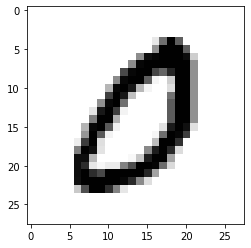

In [39]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x = x.reshape([60000, 28*28])
zeros = np.where(y==0)[0]
x = x[zeros,:]
y = y[zeros]
np.random.seed(100) # put your seed here
my_image = np.random.randint(0, len(y), size=1).item()

plt.imshow(x[my_image,:].reshape((28,28)), 
           cmap=plt.cm.gray.reversed())
plt.show()

For $k = 0, 10, 20, ...,100$, use $k$ principal components for MNIST $0$'s to approximately reconstruct the image selected above. Display the reconstruction for each value of $k$. To display the set of images compactly, you may want to use subplot, as shown in the starter code for Problem 3(c) below. You may also refer to the examples in this document: https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.subplots.html

In [40]:
xtilde = x - np.mean(x, axis = 0)
cov_matrix = (1/xtilde.shape[0]) * xtilde.T @ xtilde
evalues, evectors = np.linalg.eigh(cov_matrix)
pr_vectors_MNIS = evectors[:, np.argsort(-1*evalues)]

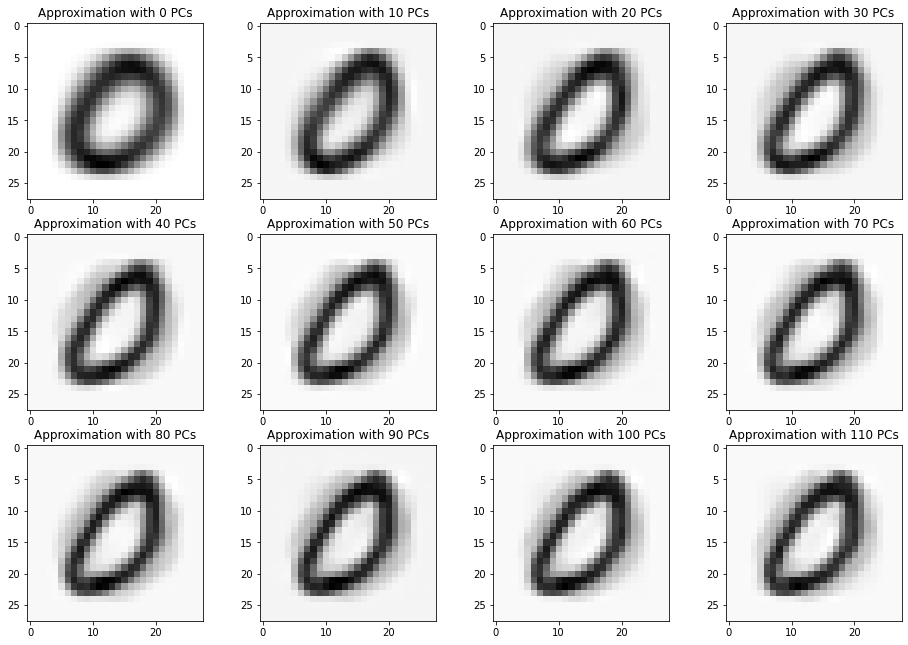

In [41]:
f, axes = plt.subplots(nrows = 3, ncols = 4, 
                       figsize = (16, 11))
axes = axes.ravel()
num = 0

for k in np.arange(0, 111, 10):
    projection_matrix = np.dot(pr_vectors_MNIS[:,0:k], 
                               (pr_vectors_MNIS[:,0:k]).T)
    capprox = np.dot(projection_matrix, x[my_image,:])
    approx = np.add(capprox.reshape((28,28)), 
                    np.mean(x, axis = 0).reshape((28,28)))
    axes[num].set_title(f'Approximation with {k} PCs')
    axes[num].imshow(approx, cmap=plt.cm.gray.reversed())
    num += 1

Your Markdown Here

#### Part (b)

Repeat Part (a), but this time for the dresses in the Fashion-MNIST dataset.

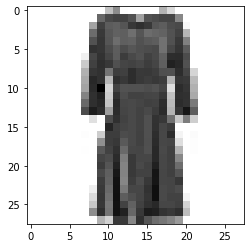

In [42]:
(x, y), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x = x.reshape([60000, 28*28])
zeros = np.where(y==3)[0]
x = x[zeros,:]
y = y[zeros]
np.random.seed(100) #put your seed here
my_image = np.random.randint(0, len(y), 
                             size=1)

plt.imshow(x[my_image,:].reshape((28,28)), 
           cmap=plt.cm.gray.reversed())
plt.show()

In [43]:
xtilde = x - np.mean(x, axis = 0)
cov_matrix = (1/xtilde.shape[0]) * xtilde.T @ xtilde
evalues, evectors = np.linalg.eigh(cov_matrix)
pr_vectors_FASH = evectors[:, np.argsort(-1*evalues)]

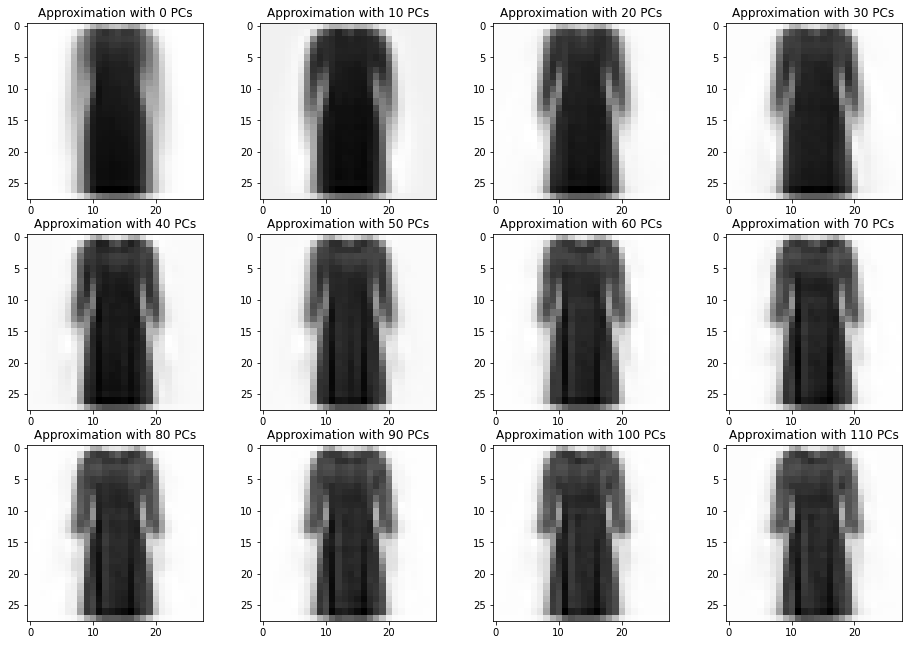

In [44]:
f, axes = plt.subplots(nrows = 3, ncols = 4, 
                       figsize = (16, 11))
axes = axes.ravel()
num = 0

for k in np.arange(0, 111, 10):
    projection_matrix = np.dot(pr_vectors_FASH[:,0:k], 
                               (pr_vectors_FASH[:,0:k]).T)
    capprox = np.dot(projection_matrix, x[my_image,:].T)
    approx = np.add(capprox.reshape((28,28)), 
                    np.mean(x, axis = 0).reshape((28,28)))
    axes[num].set_title(f'Approximation with {k} PCs')
    axes[num].imshow(approx, cmap=plt.cm.gray.reversed())
    num += 1

Your Markdown Here

#### Part (c)

Do the same thing as in Parts (a) and (b), this time reconstructing an image of Gerhard Schroeder.

In [45]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

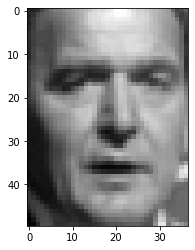

In [46]:
x = lfw_people.data
y = lfw_people.target
zeros = np.where(y==4)[0]
x = x[zeros,:]
y = y[zeros]
np.random.seed(100) #put your seed here
my_image = np.random.randint(0, len(y), size=1)


plt.imshow(x[my_image,:].reshape((50,37)), 
           cmap=plt.cm.gray)
plt.show()

In [47]:
xtilde = x - np.mean(x, axis = 0)
cov_matrix = (1/xtilde.shape[0]) * xtilde.T @ xtilde
evalues, evectors = np.linalg.eigh(cov_matrix)
pr_vectors_FACE = evectors[:, np.argsort(-1*evalues)]

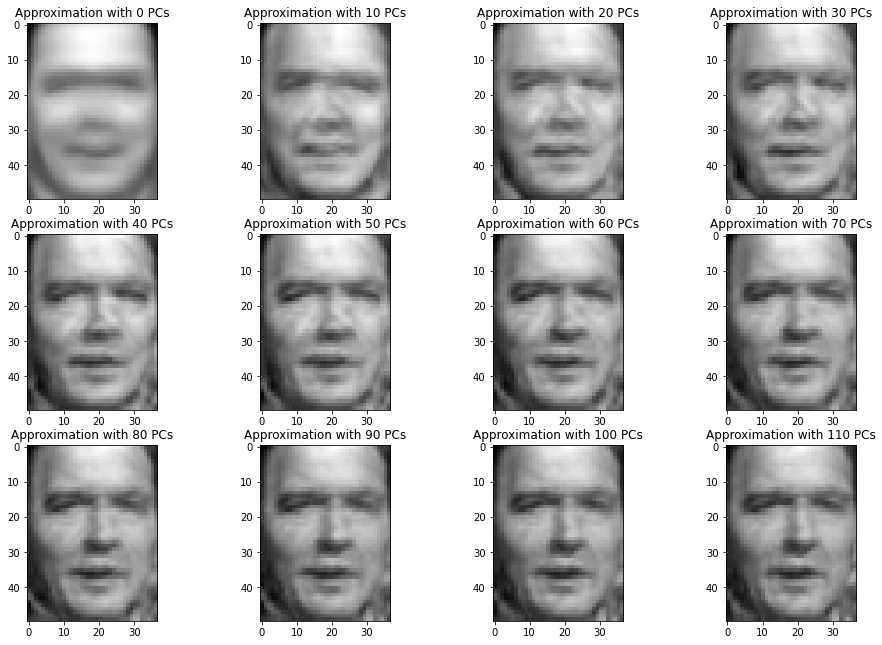

In [48]:
f, axes = plt.subplots(nrows = 3, ncols = 4, 
                       figsize = (16, 11))
axes = axes.ravel()
num = 0

for k in np.arange(0, 111, 10):
    projection_matrix = np.dot(pr_vectors_FACE[:,0:k], 
                               (pr_vectors_FACE[:,0:k]).T)
    capprox = np.dot(projection_matrix, x[my_image,:].T)
    approx = np.add(capprox.reshape((50,37)), 
                    np.mean(x, axis = 0).reshape((50,37)))
    axes[num].set_title(f'Approximation with {k} PCs')
    axes[num].imshow(approx, cmap=plt.cm.gray)
    num += 1

Your Markdown Here

### Problem 3: PCA for classification (20 Points)

#### Part (a)

Load in the MNIST data with the labels as `y` and the images as `x` by running the next cell. Create a subset of the data by keeping only the images that have the label of either $4$ or $9$. Use Principal Components Analysis (PCA) to project the data onto the first two principal components, and create a plot of the projected data color-coded by the label. Does the plot make sense? Explain in a couple sentences.

In [49]:
from sklearn.linear_model import LogisticRegression

(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x = x.reshape([60000, 28*28])
fournine = np.logical_or(y==4, y==9)
x = x[fournine,:]
y = y[fournine]

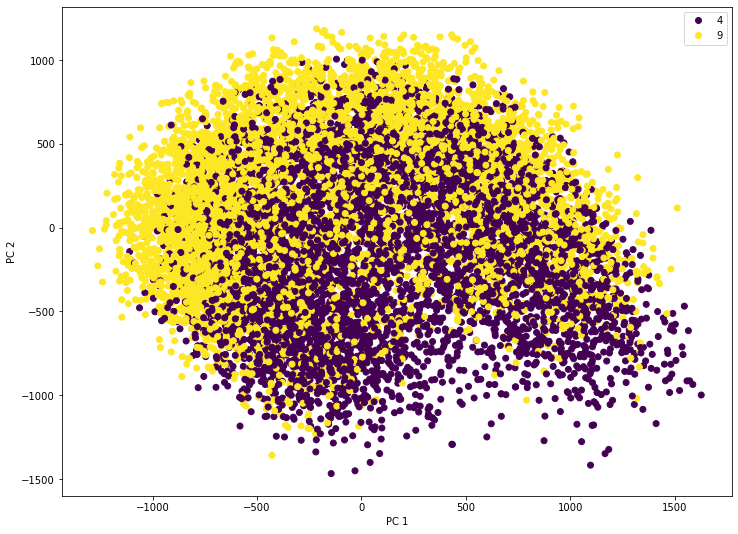

In [50]:
xtilde = x - np.mean(x, axis = 0)
cov_matrix = (1/xtilde.shape[0]) * xtilde.T @ xtilde
evalues, evectors = np.linalg.eigh(cov_matrix)
pr_vectors_MNIST = evectors[:, 
                            np.argsort(-1*evalues)]
pc_components = xtilde @ pr_vectors_MNIST

fig = plt.figure(figsize = (12, 9))

scatter = plt.scatter(pc_components[:,0], 
                      pc_components[:,1], c = y)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[4,9])
plt.xlabel(f'PC {1}')
plt.ylabel(f'PC {2}')

plt.show()

It was noticed that, when using the sklearn package for calculating the principal components compared to the manual method that I use, the principal components are different by a factor equal to -1 (which mirrors the above graph). This, however, should not change the nature of the classifier, as the only difference in the principal eigenvectors in both cases is their direction (no change in magnitude), for the rest the vectors are the same. 

The images of 4s and 9s are mostly overlapping when projecting the data on the first principal components. However, some small trend can be seen. The data that contains 9 values tends to go more in the upper left direction (low PC1, high PC2), while the data that contains the 4 values tends to go more in the lower right direction (high PC1, low PC2). Using more principal components (higher dimensions) will lead to a better separation.

#### Part (b)

Why not use more principal components? For $k = 2,3,4,...,15$, use PCA to project the data onto $k$ principal components. For each $k$, use logistic regression to build a model to classify images as $4$ or $9$, and calculate the misclassification rate. Create a plot of misclassification rate as a function of $k$, the number of principal components used. Does the plot make sense? Explain.

100%|██████████| 14/14 [01:25<00:00,  6.12s/it]


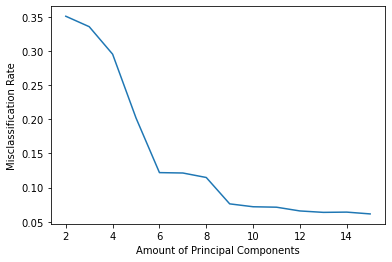

In [54]:
lr_error_rate = []

from tqdm import tqdm
for k in tqdm(np.arange(2, 16, 1)):
    X = pc_components[:,0:k]
    lr = LogisticRegression(solver='lbfgs')
    trials = 500
    errs = []
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=0.7)
        lr.fit(X_train, y_train)
        err = np.mean(lr.predict(X_test) != y_test)
        errs.append(err)
    this_err = np.mean(errs)
    lr_error_rate.append(this_err)

plt.plot(np.arange(2, 16, 1), lr_error_rate)
plt.xlabel('Amount of Principal Components')
plt.ylabel('Misclassification Rate')
plt.show()

As adding more principal components (higher dimensions) should increase the accuracy and therefore lower the misclassification rate, it makes sense that the plot is decreasing. The misclassification rate decreases drastically until 6 Principal components are used. After 9 principal components, the misclassification rate does not change significantly anymore.

#### Part (c)

Build a logistic regression model using $10$ principal components. Create a list called `misclass` that lists the indices of all images that were misclassified with this model. Does it make sense that these would be hard to classify correctly?

In [69]:
# Your Code Here, modify the lines below
keep = np.where((y==4) | (y==9))[0]
misclass = np.zeros_like(y[keep]) 

In [80]:
keep = np.where((y==4) | (y==9))[0]
X = pc_components[:,0:k]
lr = LogisticRegression(solver='lbfgs')
X_train, X_test, y_train, y_test = \
train_test_split(X, y, 
                 train_size=0.80,
                 random_state = 6)
lr.fit(X_train, y_train)

misclass = np.where(lr.predict(X_test) != y_test)[0]

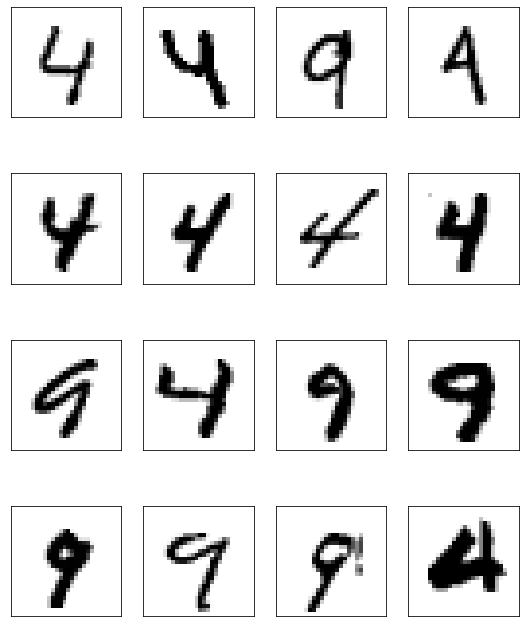

In [103]:
# The following code will display the 
# images that are misclassified
from random import sample 

images = x
np.random.seed(120)
mis_samples = sample(list(misclass),16)

plt.figure(figsize=(1.8 * 4, 2.4 * 4))
plt.subplots_adjust(bottom=0, left=.01, 
                    right=.99, top=.90, hspace=.35)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[mis_samples[i]].reshape((28, 28)), 
               cmap=plt.cm.gray.reversed())
    plt.xticks(())
    plt.yticks(())

A problem that occurs with some of the numbers 4 is that the upper two vertical lines are sometimes very curvy and close to each other (for example in the second picture), making them look like a 9. The most extreme case is the fourth and last image, were the lines are almost fully connected. This is difficult for the classifier to recognize. Another trend can be seen in row 2, where the oblique (rotated) 4s are seen as a 9.

Also with the numbers 9, it is sometimes difficult for the classifier to recognize them. Most of the 9s have a very straight "tail" making them look similar to the overall shape of a 4. The classifier also has difficulties with 9s that are do not have a fully connected circle shape in the upper part of the number.

#### Part (d)

Now use the Fashion-MNIST data and train logistic regression models to classify coats ($y=4$) and handbags ($y=8$). Again use $k = 2,3,4,...,15$ to project the data onto $k$ principal components, and calculate the misclassification rate at each $k$. Create a plot of misclassification rate vs. $k$.

Does your plot make sense? Briefly interpret it in 2-3 sentences.

In [19]:
(x, y), (x_test, y_test) = \
tf.keras.datasets.fashion_mnist.load_data()
fashion = x.reshape([60000, 28*28])
foureight = np.logical_or(y==4, y==8)
x = fashion[foureight,:]
y = y[foureight]

xtilde = x - np.mean(x, axis = 0)
cov_matrix = (1/xtilde.shape[0]) * xtilde.T @ xtilde
evalues, evectors = np.linalg.eigh(cov_matrix)
pr_vectors_FASHM = evectors[:, np.argsort(-1*evalues)]
pc_components = xtilde @ pr_vectors_FASHM

100%|██████████| 14/14 [02:23<00:00, 10.22s/it]


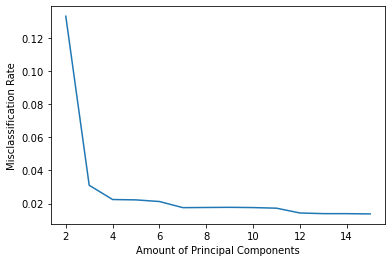

In [20]:
lr_error_rate = []

from tqdm import tqdm
for k in tqdm(np.arange(2, 16, 1)):
    X = pc_components[:,0:k]
    lr = LogisticRegression(solver='lbfgs')
    trials = 500
    errs = []
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=0.70)
        lr.fit(X_train, y_train)
        err = np.mean(lr.predict(X_test) != y_test)
        errs.append(err)
    this_err = np.mean(errs)
    lr_error_rate.append(this_err)

plt.plot(np.arange(2, 16, 1), lr_error_rate)
plt.xlabel('Amount of Principal Components')
plt.ylabel('Misclassification Rate')
plt.show()

Adding more principal components (higher dimensions) will increase the accuracy and therefore lower the misclassification rate, which is why the plot is decreasing. Generally, the misclassification rate is significantly lower compared to the numbers dataset. While the classifier in the numbers dataset required 6 to 9 principal components to be acceptable, the fashion classifier already does a great job even with 3 or 4 principal components.